<a href="https://colab.research.google.com/github/ageryw/UncertaintyInMosquitoClassification/blob/main/Uncertainty%20in%20Mosquito%20Alert%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VGG 16**
---

## **Train**

In [ ]:
#For Pretrained VGG Model
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import h5py
from scipy.ndimage.interpolation import rotate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import os
import copy

In [ ]:
!unzip Mosq.zip
!rm Mosq.zip

In [ ]:
!mv  Mosq/val  Mosq/test

In [ ]:
loss_ = []
test_accuracy = []
test_error = []

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Mosq/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from math import sqrt

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'test':
                test_accuracy.append(epoch_acc)
                test_error.append(int(dataset_sizes[phase]*(1-test_accuracy[-1])))
                loss_.append(epoch_loss)
                print('Test error: {}; test accuracy: {}'.format(test_error[-1], test_accuracy[-1]))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Train the model
net_trained = train_model(net_trained, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
torch.save(net_trained,'model1.h5')

In [ ]:
testa = []
for i, val in enumerate(test_accuracy):
  testa.append(val.item())

print(test_error)
print(loss_)
print(testa)

In [ ]:
model_ft = models.vgg16(pretrained=True)
feats_list = list(model_ft.features)
new_feats_list = []
for feat in feats_list:
    new_feats_list.append(feat)
    if isinstance(feat, nn.Conv2d):
        new_feats_list.append(nn.Dropout(p=0.5, inplace=True))
# modify convolution layers
model_ft.features = nn.Sequential(*new_feats_list)
model_ft.classifier[2] = nn.Dropout (p = 0.4)
model_ft.classifier[5] = nn.Dropout (p = 0.4)
num_ftrs = model_ft.classifier[6].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[6] = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [ ]:
model_ft

In [ ]:
# Train the model
net_trained = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
torch.save(model_ft,'model2.h5')

In [ ]:
model_ft1 = models.vgg16(pretrained=True)
feats_list = list(model_ft1.features)
new_feats_list = []
i=0
for feat in feats_list:
    new_feats_list.append(feat)
    if isinstance(feat, nn.Conv2d) and i == 0:
        new_feats_list.append(nn.Dropout(p=0.1, inplace=True))
        i += 1
    elif isinstance(feat, nn.Conv2d):
        new_feats_list.append(nn.Dropout(p=0.5, inplace=True))
        i += 1
# modify convolution layers
model_ft1.features = nn.Sequential(*new_feats_list)
#num_ftrs = model_ft.classifier[0].out_features
model_ft1.classifier[2] = nn.Dropout (p = 0.1)
model_ft1.classifier[5] = nn.Dropout (p = 0.1)
num_ftrs = model_ft1.classifier[6].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft1.classifier[6] = nn.Linear(num_ftrs, 2)
model_ft1 = model_ft1.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft1.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# Train the model
model_ft1 = train_model(model_ft1, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
torch.save(model_ft1,'model4.h5')

## **Cross-Val**

In [ ]:
# Configuration options
k_folds = 5
num_epochs = 25
criterion = nn.CrossEntropyLoss()

# For fold results
results = {}

# Set fixed random number seed
torch.manual_seed(42)
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = 'Mosq/'
dataset = datasets.ImageFolder(data_dir, data_transforms)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)
  
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
  
  # Print
  print(f'FOLD {fold}')
  print('--------------------------------')
  
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(
                    dataset, 
                    batch_size=64, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=64, sampler=test_subsampler)
  
  # Init the neural network
  model_ft = models.vgg16(pretrained=True)
  feats_list = list(model_ft.features)
  new_feats_list = []
  for feat in feats_list:
      new_feats_list.append(feat)
      if isinstance(feat, nn.Conv2d):
          new_feats_list.append(nn.Dropout(p=0.5, inplace=True))
  # modify convolution layers
  model_ft.features = nn.Sequential(*new_feats_list)
  model_ft.classifier[2] = nn.Dropout (p = 0.4)
  model_ft.classifier[5] = nn.Dropout (p = 0.4)
  num_ftrs = model_ft.classifier[6].in_features
  # Here the size of each output sample is set to 2.
  # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
  model_ft.classifier[6] = nn.Linear(num_ftrs, 2)
  model_ft = model_ft.to(device)
  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
  # Decay LR by a factor of 0.1 every 7 epochs
  #exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
  #optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
  # Run the training loop for defined number of epochs
  for epoch in range(0, num_epochs):
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    # Set current loss value
    current_loss = 0.0
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader):
      # Get inputs
      inputs, targets = data  
      inputs, targets = inputs.cuda(), targets.cuda()    
      # Zero the gradients
      optimizer_ft.zero_grad()     
      # Perform forward pass
      outputs = model_ft(inputs)   
      # Compute loss
      loss = criterion(outputs, targets)  
      # Perform backward pass
      loss.backward()  
      # Perform optimization
      optimizer_ft.step()
      # Print statistics
      current_loss += loss.item()
      #if i % 500 == 499:
  print(f'Loss: {current_loss/len(trainloader)}')
  #current_loss = 0.0
          
  # Process is complete.
  print('Training process has finished. Saving trained model.')
  # Print about testing
  print('Starting testing')
  # Saving the model
  save_path = f'./model-fold-{fold}.pth'
  torch.save(model_ft.state_dict(), save_path)

  # Evaluationfor this fold
  correct, total = 0, 0
  with torch.no_grad():

    # Iterate over the test data and generate predictions
    for i, data in enumerate(testloader, 0):

      # Get inputs
      inputs, targets = data
      inputs, targets = inputs.cuda(), targets.cuda() 
      # Generate outputs
      outputs = model_ft(inputs)

      # Set total and correct
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += (predicted == targets).sum().item()

    # Print accuracy
    print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
    print('--------------------------------')
    results[fold] = 100.0 * (correct / total)
  
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  sum += value
print(f'Average: {sum/len(results.items())} %')

## **Scatter Plot**

In [ ]:
def predict_class(model, X):
    model = model.eval()
    outputs = model(Variable(X))
    _, pred = torch.max(outputs.data, 1)
    model = model.train()
    return pred.numpy()

def predict(model, X, T=100):
    standard_pred = predict_class(model, X)
    y1 = []
    y2 = []
    for _ in range(T):
        _y1 = model(Variable(X))
        _y2 = F.softmax(_y1, dim=1)
        y1.append(_y1.data.numpy())
        y2.append(_y2.data.numpy())
    return standard_pred, np.array(y1), np.array(y2)

In [ ]:
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}
data_dir = 'Mosq/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                    for x in ['test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                  shuffle=True, num_workers=4) for x in ['test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

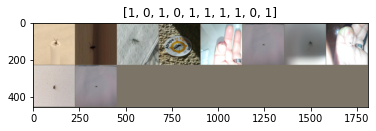

Image Classes: [1, 0, 1, 0, 1, 1, 1, 1, 0, 1]


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

# Get a batch of training data
testloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=10, shuffle=True)
X_test, y_test = next(iter(testloader))
class_names = image_datasets['test'].classes
# Make a grid from batch
out = torchvision.utils.make_grid(X_test)
imshow(out, title=[x.item() for x in y_test]) 
print(f'Image Classes: {[x.item() for x in y_test]}')

In [ ]:
vgg1_models = torch.load('model1.h5',map_location={'cuda:0': 'cpu'})
model = vgg1_models
#model = vgg2_models
# Need to flatten X1 before feeding into MLP
X1 = np.array(X_test)
y1_pred, y1_si, y1_so = predict(model, torch.from_numpy(X1))
print('Predictions: {}'.format(y1_pred))

Predictions: [1 0 1 0 1 1 1 0 1 1]


In [ ]:
vgg2_models = torch.load('model1.h5',map_location={'cuda:0': 'cpu'})
model2 = vgg2_models
#model = vgg2_models
# Need to flatten X1 before feeding into MLP
X1 = np.array(X_test)
y1_pred, y1_si, y1_so = predict(model2, torch.from_numpy(X1))
print('Predictions: {}'.format(y1_pred))

Predictions: [1 0 1 0 0 1 1 0 1 1]


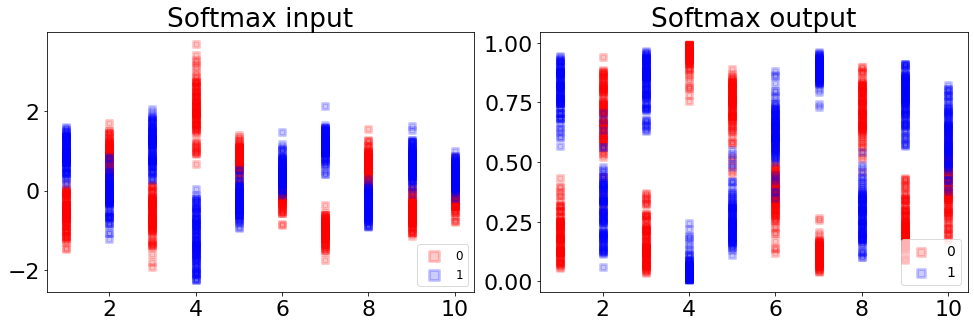

In [ ]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(np.tile(np.arange(1, 11), y1_si.shape[0]), y1_si[:, :, 0].flatten(), \
            color='r', marker='s', linewidth=3, alpha=0.2, label='0');
plt.scatter(np.tile(np.arange(1, 11), y1_si.shape[0]), y1_si[:, :, 1].flatten(), \
           color='b', marker='s', linewidth=3, alpha=0.2, label='1');
plt.title('Softmax input');
lgnd = plt.legend(framealpha=0.7, loc = 'lower right', fontsize=12, scatterpoints=1);
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]

plt.subplot(1, 2, 2)
plt.scatter(np.tile(np.arange(1, 11), y1_so.shape[0]), y1_so[:, :, 0].flatten(), \
            color='r', marker='s', linewidth=3, alpha=0.2, label='0');
plt.scatter(np.tile(np.arange(1, 11), y1_so.shape[0]), y1_so[:, :, 1].flatten(), \
            color='b', marker='s', linewidth=3, alpha=0.2, label='1');

plt.title('Softmax output');
lgnd = plt.legend(framealpha=0.7, loc = 'lower right', fontsize=14, scatterpoints=1);
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]

plt.tight_layout();
#Input: [1 0 1 0 1 1 1 1 0 1]
#Pred:  [1 0 1 0 0 1 1 0 1 1]

## **Generate Histograms**

In [ ]:
from __future__ import print_function
import math
import matplotlib.pyplot as plt
import os

import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import warnings
warnings.simplefilter(action='ignore')

def apply_dropout(m):
    for each_module in m.children():
        if each_module.__class__.__name__.startswith('Dropout'):
            each_module.train()
    return m

def enable_dropout(m):
  for each_module in m.modules():
    if each_module.__class__.__name__.startswith('Dropout'):
      each_module.train()

def uncertainties(p):
    aleatoric = np.mean(p*(1-p), axis=0)
    epistemic = np.mean(p**2, axis=0) - np.mean(p, axis=0)**2
    return aleatoric, epistemic


In [ ]:
#----------------------------CHOOSE RANDOM IMAGE----------------------------------------------
for test_images, test_labels in dataloaders['test']:  
    sample_image = test_images[2]
    sample_label = test_labels[2]

T = 100 # how many times to apply drop-out at test time

In [ ]:
sample_label

tensor(0)

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    #plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
#sns.set(rc={'figure.figsize':(14,6)})
#plt.gcf().set_size_inches(11.7, 8.27)
def plothist(grdtruth, prediction, flag):
  #for i in prediction:
  mean = np.mean(prediction)
  std = np.std(prediction)
  if std>=0.1:
    dec = "Uncertain"
  else:
    dec = "Certain"
  if flag == 1 and std <= 0.1:
    sns.displot(prediction, kind="kde", bw_adjust=.6, fill=True, color= '#ff6c70', label = 'Correct', legend=True)
  elif flag == 1 and std > 0.1:
    sns.displot(prediction, kind="kde", bw_adjust=.6, fill=True, color= '#ff6c70', label = 'Correct', legend=True)
  else:
    #sns.displot(grdtruth, kind="kde", bw_adjust=.6, fill=True, color= '#ff6c70', label = 'Grd Truth')
    #sns.displot(prediction, kind="kde", bw_adjust=.6, fill=True, color= '#00DBFF', label = 'Pred.')
    sns.displot([grdtruth, prediction], kind="kde", bw_adjust=.6, fill=True,
                color= ['#ff6c70',  '#00DBFF'], legend=True)
  #sns.displot(ntpred, kind="kde", bw_adjust=.6, fill=True, color='#ff6c70', label = 'incorrect', legend=True)
  
  plt.title("$μ$: {:.3f} $σ$: {:.3f}  {}".format(mean, std, dec), loc='left', fontsize=22)
  #plt.text("$σ$: {:.3f}  {}".format(std, dec), fontsize=14, ha='center', va='center')
  #plt.title("p(Tiger | image)", fontsize=20)
  plt.xlabel("Observations", fontsize=20)
  plt.ylabel("Density", fontsize=20)
  #plt.legend()
  #sns.displot(prediction[1], kind="kde", bw_adjust=.6, fill=True, color='#EF9A9A')
  #sns.plt.show()

In [ ]:
import numpy as np
pred = []
#----------------------------PREDICT-------------------------------------------
def predict(model, image, label, T=T):
    enable_dropout(model)
    # prepare label
    label = label.item()
    # prepare image
    #image = image.flatten()
    image = image.unsqueeze(0).to(device)
    #image.to(device)
    standard_output = model(image)
    _, standard_prediction = standard_output.max(0)
    model.train()
    # each vector will consist of T elements- the class-specific predictive probability from each model
    zero_p_hat= []
    one_p_hat= []

    #for idx, (images, labels) in enumerate(test_lloader):
            #images = images.to(device)
            #labels = labels.to(device)
    # predict stochastic dropout model T times
    for t in range(T):
        enable_dropout(model) 
        output = model(Variable(image))
        output = output.detach().cpu()
        output_prob1 = np.exp(output) #convert to predictive probabilities
        output_prob = F.softmax(output_prob1, dim=1)
        zero_p_hat.append(output_prob[0][0].item()) # P( c = 0 | image)
        one_p_hat.append(output_prob[0][1].item()) # P( c = 1 | image)

    # mean prediction
    zero_var = np.var(zero_p_hat)
    one_var = np.var(one_p_hat)

    #pred = zero_p_hat
    
    # will be a list of 10 elements, the variance of each class's predictions across T models
    class_specific_uncertainties = [zero_var, one_var]
    variance_of_class_specific_predictions = class_specific_uncertainties[label]
    p_hat_lists = [zero_p_hat, one_p_hat]
    

    return standard_prediction[0].item(), variance_of_class_specific_predictions, p_hat_lists[label], p_hat_lists

In [ ]:
# Dropout at test-time for uncertainty estimation
vgg1_models = torch.load('model1.h5',map_location={'cuda:0': 'cpu'})
vgg1_models.to(device)
prediction, var_uncertainty, samplePred, allSamples = predict(vgg1_models, sample_image, sample_label)

print(f'The model predicts: {prediction} ')
print(f'The ground truth: {sample_label}')
print(f'The number of samplings: {T}')
print(f'Variance of class-specific predictions across the models: {var_uncertainty}')
#print(f'Aleatoric and epistemic uncertainty: {aleatoric}')
#print(f'Epistemic uncertainty: {epistemic}')
#print(f'Moodels predictive probability: {_}')
#imshow(inp = sample_image, title = sample_label)
lbl = sample_label.item()
imshow(inp = sample_image, title = lbl)
if prediction == sample_label:
  flag = 1
else:
  flag = 0
plothist(allSamples[lbl], allSamples[prediction], flag)

In [ ]:
#----------------------------CHOOSE RANDOM IMAGE----------------------------------------------
for test_images, test_labels in dataloaders['test']:  
    sample_image = test_images[2]
    sample_label = test_labels[2]

T = 100 
sample_label

tensor(1)

The model predicts: 0 
The ground truth: 0
The number of samplings: 100
Variance of class-specific predictions across the models: 0.007723053213434197


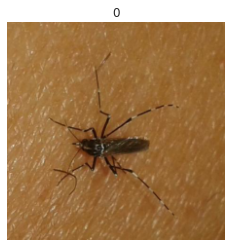

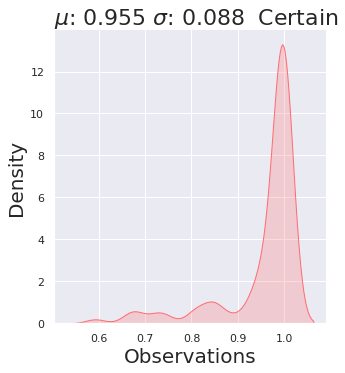

In [ ]:
# Dropout at test-time for uncertainty estimation
vgg2_models = torch.load('model2.h5',map_location={'cuda:0': 'cpu'})
vgg2_models.to(device)
prediction, var_uncertainty, samplePred, allSamples = predict(vgg2_models, sample_image, sample_label)

print(f'The model predicts: {prediction} ')
print(f'The ground truth: {sample_label}')
print(f'The number of samplings: {T}')
print(f'Variance of class-specific predictions across the models: {var_uncertainty}')
#print(f'Aleatoric and epistemic uncertainty: {aleatoric}')
#print(f'Epistemic uncertainty: {epistemic}')
#print(f'Moodels predictive probability: {_}')
#imshow(inp = sample_image, title = sample_label)
lbl = sample_label.item()
imshow(inp = sample_image, title = lbl)
if prediction == sample_label:
  flag = 1
else:
  flag = 0
plothist(allSamples[lbl], allSamples[prediction], flag)

## **Test-with Rejection(Fixed Uncertainty)**

In [ ]:
#For Pretrained VGG Model
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import h5py
from scipy.ndimage.interpolation import rotate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import os
import copy
device = torch.device("cuda")
#model = Net()
#model.load_state_dict(torch.load('model.h5', map_location="cuda:0"))  # Choose whatever GPU device number you want
#model.to(device)
#model.eval()
#net_trained = torch.load('model.h5')
model_ft = torch.load('model2.h5')
#model_ft.to(device)

In [ ]:
def apply_dropout(m):
    for each_module in m.children():
        if each_module.__class__.__name__.startswith('Dropout'):
            each_module.train()
    return m

def enable_dropout(m):
  for each_module in m.modules():
    if each_module.__class__.__name__.startswith('Dropout'):
      each_module.train()

def uncertainties(p):
    aleatoric = np.mean(p*(1-p), axis=0)
    epistemic = np.mean(p**2, axis=0) - np.mean(p, axis=0)**2
    return aleatoric, epistemic

In [ ]:
import numpy as np

out_std = []
output_var = []
eps_list = []
al_list = []
T = 50
#predlist=torch.zeros(0,dtype=torch.long, device='cpu')
#lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
predlist=[]
lbllist=[]

lr_probsDr0 = []
lr_probsDr1 = []
testyDr = []

In [ ]:
def mcdropout(model):
    enable_dropout(model)
    model.train()
    correct = 0
    T = 10
    predicted_for_images = 0
    correct_predictions=0
    skipped = 0
    flag = None
    test_loss = 0
    for idx, (images, labels) in enumerate(testloader):
        #images = images.view(-1, 3*224*224)
        if idx%100 == 0:
          print(f'{idx}/{len(testloader)}')
        images = images.to(device)
        #images = images.unsqueeze(0).to(device)
        #print(images.shape)
        labels = labels.to(device)
        #for images,labels in testloader:
        #zero_p_hat = []
        #one_p_hat = []
        output_list = []
        p_hat_lists = []
        zero_p_hat= []
        one_p_hat= []
        #histo_exp = []
        for i in range(T):
            enable_dropout(model) 
            out = torch.unsqueeze(F.softmax(model(images)), 0)

            output_list.append(out)
            output = out.detach()
            output_prob = np.asarray(output.cpu()).squeeze() #convert to predictive probabilities

        output_mean = torch.cat(output_list, 0).mean(0)
        output_variance = torch.cat(output_list, 0).var(0).mean().data
        unct_list = output_variance.cpu().data.numpy()
        output_std = torch.cat(output_list, 0).std(0).mean()
        std_list = output_std.cpu().data.numpy()
        #print(std_list.item())
        out_std.append(std_list)
        output_var.append(unct_list)

        #epistemic = np.mean(torch.cat(output_list, 0).cpu().data.numpy()**2, axis=0) - np.mean(torch.cat(output_list, 0).cpu().data.numpy(), axis=0)**2
        #print(f'std = {output_std}')

        confidence = output_mean.data.cpu().numpy().max()   
        test_loss = F.nll_loss(F.log_softmax(output_mean,dim=1), labels, reduction='sum').data  # sum up batch loss
        #test_loss = F.nll_loss(output_mean, labels, reduction='sum').data
        _, predicted  = torch.max(output_mean, 1) # get the index of the max log-probability
        pred_list = predicted.cpu().data.numpy()
        correct = (predicted == labels).sum().item()

        p_hat_lists = [zero_p_hat, one_p_hat]
        p = np.array(p_hat_lists[labels])

        epistemic = np.mean(p**2, axis=0) - (np.mean(p, axis=0)**2)
        aleatoric = np.mean(p*(1-p), axis=0)
        eps_list.append(epistemic)
        al_list.append(aleatoric)

        if(std_list <= 0.1):
            predicted_for_images += 1
            #predlist=torch.cat([predlist,predicted.item().cpu()])
            #lbllist=torch.cat([lbllist,labels.item().cpu()])
            predlist.append(predicted.item())
            lbllist.append(labels.item())

            lr_probsDr0.append(output_mean[:,0].item())
            lr_probsDr1.append(output_mean[:,1].item())
            testyDr.append(labels.item())

            if(labels==predicted):
                #print("Correct")
                correct_predictions +=1.0
                flag = 'Correct'
            else:
                #print("Incorrect :()")
                flag = 'Incorrect'
        else:
            flag = 'Undecided'
            skipped += 1

    return len(testloader), correct_predictions, predicted_for_images, skipped

In [ ]:
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}
data_dir = 'Mosq/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                    for x in ['test']}
testloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=1, shuffle=True)
class_names = image_datasets['test'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#ckpt_dropout = torch.load('vgg1_last_mod.pth')
#ckpt_dropout.load_state_dict(ckpt_dropout)
total, correct, predictions, skipped = mcdropout(model_ft)
print("Total images: ", total)
print("Skipped1: ", skipped)
print("Skipped: ", total - predictions)
print("Correct Prediction: {}/{}".format(correct, predictions))
print(f'Wrong predictions {predictions-correct}')
print("Accuracy when made predictions: %d %%" % (100 * correct / predictions))

0/1275
100/1275
200/1275
300/1275
400/1275
500/1275
600/1275
700/1275
800/1275
900/1275
1000/1275
1100/1275
1200/1275
Total images:  1275
Skipped1:  430
Skipped:  430
Correct Prediction: 778.0/845
Wrong predictions 67.0
Accuracy when made predictions: 92 %


In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  525384 KB |    2975 MB |    3525 GB |    3524 GB |\n|       from large pool |  524288 KB |    2880 MB |    3448 GB |    3447 GB |\n|       from small pool |    1096 KB |      95 MB |      76 GB |      76 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |  525384 KB |    2975 MB |    3525 GB |    3524 GB |\n|       from large pool |  524288 KB |    2880 MB |

### **Local Conf Mat**

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[555   8]
 [ 59 223]]


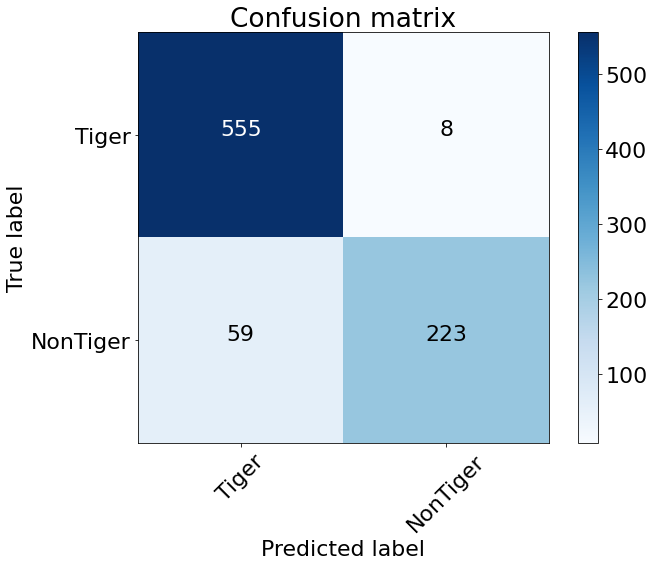

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
plt.rcParams.update({'font.size': 22})
nb_classes = 2
cm = confusion_matrix(np.array(lbllist), np.array(predlist))

plt.figure(figsize=(10,8))
names = (
    'Tiger'
    ,'NonTiger'
)
plot_confusion_matrix(cm, names)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.array(lbllist), np.array(predlist)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       457
           1       0.97      0.97      0.97       379

    accuracy                           0.97       836
   macro avg       0.97      0.97      0.97       836
weighted avg       0.97      0.97      0.97       836



## **Test With Rejection (N% Rejection)**

In [ ]:
#Test N% of most accurate datasets.
from torch.autograd import Variable
#from pytorch_lightning import metrics
#valid_accuracy = metrics.Accuracy(compute_on_step=False)
from operator import itemgetter
import torch
from torch.nn import functional as F

def test(model, test_loader, device):
  test_cases = [1, 0.9, 0.8, 0.7, 0.6, 0.4, 0.2]
  zipV = []
  #zipV = []
  acc = []
  correct = []
  correctfromrejected = []
  test_loss = 0
  criterion = nn.CrossEntropyLoss()
  model.eval()
  with torch.no_grad():
      for batch in test_loader:
          
          data, target = batch
          data, target = data.to(device), target.to(device)
          output = model(data)
          probabilities = F.softmax(output, dim=1)
          # Keep only the top class confidence for each sample
          most_probable = torch.max(probabilities, dim=1)[0]
          prediction = output.argmax(dim=1, keepdim=True)
          temp = [i for i in zip(target,most_probable,prediction)]
          sortedTemp = sorted(temp, key=itemgetter(1), reverse=True)

          test_loss += criterion(output.squeeze(), target.squeeze()).item()  # sum up batch loss
          #prediction = output.argmax(dim=1, keepdim=True)
          zipV.extend(sortedTemp)
      zipV = sorted(zipV, key=itemgetter(1), reverse=True)
      for i in range(len(test_cases)):
        N = int(test_cases[i]*len(zipV))
        selForEval = zipV[0:N+1]
        rejected = zipV[N+2:]
        corectpred = 0
        for k in range(len(selForEval)):
            if selForEval[k][0] == selForEval[k][2]:
                corectpred += 1
        correct.append(corectpred)
        acc.append(corectpred/len(selForEval))
        correctfromrej = 0
        for l in range(len(rejected)):
            if rejected[l][0] == rejected[l][2]:
                correctfromrej += 1
        correctfromrejected.append(correctfromrej)
        #print(f'Acc:{acc:.2f}%')
        #test_loss /= len(test_loader.dataset)
        trejected = len(zipV)-N
        correctfreje = correctfromrejected[i]
        print(f'==>Correct: {correct[i]}/{N}, Test error: {N-correct[i]}/{N}, Test Accuracy 2: {acc[i]:.2f}')
        if test_cases[i]!= 1:
          print(f'Reference operating point:{zipV[N+1]},{zipV[N+2]}')
        print(f'==>Correct But Rejected: {correctfreje}/{trejected}')
        print(f'Error But Reje: {trejected - correctfreje}/{trejected}')
        print(f'=====================================================================')
        #writer.add_scalar(f'Runs/Loss/test2', test_loss, epoch)
        #writer.add_scalar(f'Runs/Accuracy/test2', acc, epoch)

In [ ]:
model_ft = torch.load('model2.h5')
test(model_ft, dataloaders['test'], device)

==>Correct: 1143/1275, Test error: 132/1275, Test Accuracy 2: 0.90
==>Correct But Rejected: 0/0
Error But Reje: 0/0
==>Correct: 1062/1147, Test error: 85/1147, Test Accuracy 2: 0.93
Reference operating point:(tensor(0, device='cuda:0'), tensor(0.5916, device='cuda:0'), tensor([0], device='cuda:0')),(tensor(1, device='cuda:0'), tensor(0.5915, device='cuda:0'), tensor([1], device='cuda:0'))
==>Correct But Rejected: 80/128
Error But Reje: 48/128
==>Correct: 965/1020, Test error: 55/1020, Test Accuracy 2: 0.95
Reference operating point:(tensor(0, device='cuda:0'), tensor(0.6638, device='cuda:0'), tensor([0], device='cuda:0')),(tensor(0, device='cuda:0'), tensor(0.6633, device='cuda:0'), tensor([0], device='cuda:0'))
==>Correct But Rejected: 177/255
Error But Reje: 78/255
==>Correct: 854/892, Test error: 38/892, Test Accuracy 2: 0.96
Reference operating point:(tensor(1, device='cuda:0'), tensor(0.7143, device='cuda:0'), tensor([1], device='cuda:0')),(tensor(1, device='cuda:0'), tensor(0.714

In [ ]:
#Test N% of most accurate datasets.
from torch.autograd import Variable
#from pytorch_lightning import metrics
#valid_accuracy = metrics.Accuracy(compute_on_step=False)
from operator import itemgetter
import torch
from torch.nn import functional as F

def testRandom(model, test_loader, device):
  test_cases = [1, 0.9, 0.8, 0.7, 0.6, 0.4, 0.2]
  zipV = []
  acc = []
  correct = []
  correctfromrejected = []
  test_loss = 0
  criterion = nn.CrossEntropyLoss()
  model.eval()
  with torch.no_grad():
      for batch in test_loader:
          
          data, target = batch
          data, target = data.to(device), target.to(device)
          output = model(data)
          probabilities = F.softmax(output, dim=1)
          # Keep only the top class confidence for each sample
          most_probable = torch.max(probabilities, dim=1)[0]
          prediction = output.argmax(dim=1, keepdim=True)
          temp = [i for i in zip(target,most_probable,prediction)]
          #sortedTemp = sorted(temp, key=itemgetter(1), reverse=True)
          test_loss += criterion(output.squeeze(), target.squeeze()).item()  # sum up batch loss
          #prediction = output.argmax(dim=1, keepdim=True)
          zipV.extend(temp)
      for i in range(len(test_cases)):
        N = int(test_cases[i]*len(zipV))
        selForEval = zipV[0:N+1]
        rejected = zipV[N+2:]
        corectpred = 0
        for k in range(len(selForEval)):
            if selForEval[k][0] == selForEval[k][2]:
                corectpred += 1
        correct.append(corectpred)
        acc.append(corectpred/len(selForEval))
        correctfromrej = 0
        for l in range(len(rejected)):
            if rejected[l][0] == rejected[l][2]:
                correctfromrej += 1
        correctfromrejected.append(correctfromrej)
        #print(f'Acc:{acc:.2f}%')
        #test_loss /= len(test_loader.dataset)
        trejected = len(zipV)-N
        correctfreje = correctfromrejected[i]
        print(f'==>Correct: {correct[i]}/{N}, Test error: {N-correct[i]}/{N}, Test Accuracy 2: {acc[i]:.2f}')
        if test_cases[i]!= 1:
          print(f'Reference operating point:{zipV[N+1]},{zipV[N+2]}')
        print(f'==>Correct But Rejected: {correctfreje}/{trejected}')
        print(f'Error But Reje: {trejected - correctfreje}/{trejected}')
        print(f'=====================================================================')
        #writer.add_scalar(f'Runs/Loss/test2', test_loss, epoch)
        #writer.add_scalar(f'Runs/Accuracy/test2', acc, epoch)

In [ ]:
#model_ft = torch.load('model2.h5')
testRandom(model_ft, dataloaders['test'], device)

==>Correct: 1143/1275, Test error: 132/1275, Test Accuracy 2: 0.90
==>Correct But Rejected: 0/0
Error But Reje: 0/0
==>Correct: 1029/1147, Test error: 118/1147, Test Accuracy 2: 0.90
Reference operating point:(tensor(1, device='cuda:0'), tensor(0.7623, device='cuda:0'), tensor([1], device='cuda:0')),(tensor(0, device='cuda:0'), tensor(0.7628, device='cuda:0'), tensor([0], device='cuda:0'))
==>Correct But Rejected: 113/128
Error But Reje: 15/128
==>Correct: 913/1020, Test error: 107/1020, Test Accuracy 2: 0.89
Reference operating point:(tensor(0, device='cuda:0'), tensor(0.5516, device='cuda:0'), tensor([1], device='cuda:0')),(tensor(0, device='cuda:0'), tensor(0.8450, device='cuda:0'), tensor([0], device='cuda:0'))
==>Correct But Rejected: 230/255
Error But Reje: 25/255
==>Correct: 801/892, Test error: 91/892, Test Accuracy 2: 0.90
Reference operating point:(tensor(0, device='cuda:0'), tensor(0.6967, device='cuda:0'), tensor([0], device='cuda:0')),(tensor(0, device='cuda:0'), tensor(0.

## **Generate Confusion Martix**

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[534  20]
 [ 36 431]]


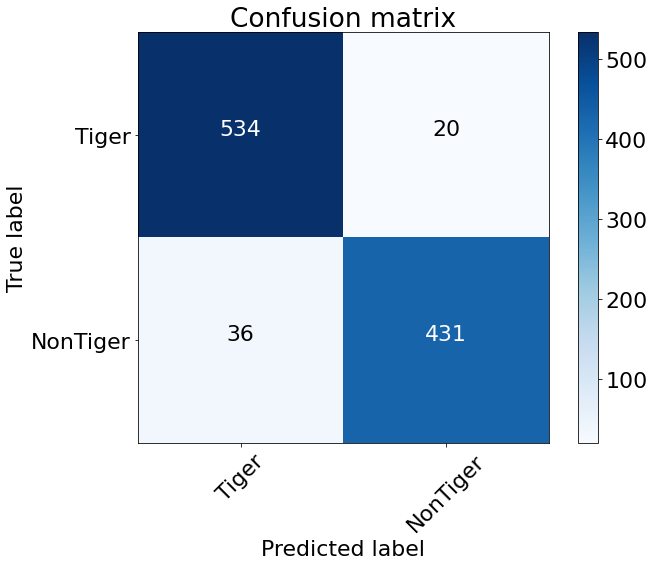

In [ ]:
from sklearn.metrics import confusion_matrix
nb_classes = 2
# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
most_probable=torch.zeros(0,dtype=torch.long, device='cpu')

predlist2=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist2=torch.zeros(0,dtype=torch.long, device='cpu')

test_cases = 0.8
zipV = []
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])
        most_probable = torch.cat([most_probable, F.softmax(outputs, dim=1).cpu()])
        #torch.max (torch.tensor([[0.5571, 0.4429]]), 1)[0].item()
        ###################################333
        #probabilities = F.softmax(output, dim=1)
        # Keep only the top class confidence for each sample
        #prediction = output.argmax(dim=1, keepdim=True)
        #temp = [i for i in zip(lbllist, predlist,most_probable)]
        #sortedTemp = sorted(temp, key=itemgetter(2), reverse=True)
        #prediction = output.argmax(dim=1, keepdim=True)
        #zipV.extend(sortedTemp)
        #zipV = sorted(zipV, key=itemgetter(2), reverse=True)
          ####################################3
        # Append batch prediction results
temp, ind = torch.max(most_probable, dim=1)
sorted, indices = torch.sort(temp, descending=True)
N = int(test_cases*len(sorted))
#predlist2= zipV[1][0:N+1]])
#lbllist2= zipV[0][0:N+1]])
predlist2 = predlist[indices][0:N+1]
lbllist2 = lbllist[indices][0:N+1]
cm = confusion_matrix(lbllist2.numpy(), predlist2.numpy())

#import seaborn as sns
#names = ('AeAl', 'NoAeAl')
plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(10,8))
#sns.heatmap(confusion_matrix(testGen.classes, y_pred), annot=True, fmt="d")
#sns.heatmap(confusion_matrix(testGen.classes, names), annot=True, fmt="d")
names = (
    'Tiger'
    ,'NonTiger'
)

plot_confusion_matrix(cm, names)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(lbllist2.numpy(), predlist2.numpy()))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       554
           1       0.96      0.92      0.94       467

    accuracy                           0.95      1021
   macro avg       0.95      0.94      0.94      1021
weighted avg       0.95      0.95      0.95      1021



Confusion matrix, without normalization
[[506  49]
 [ 58 407]]


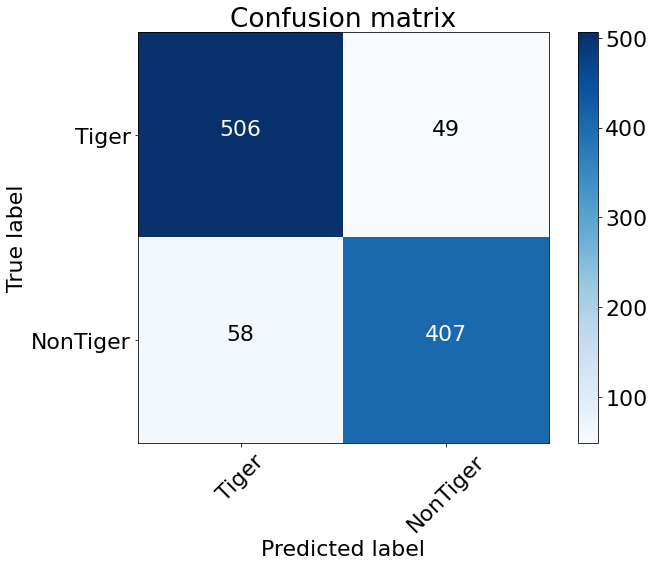

In [ ]:
from sklearn.metrics import confusion_matrix
nb_classes = 2
test_cases = 0.8
# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

N = int(test_cases*len(lbllist))
cm = confusion_matrix(lbllist[0:N].numpy(), predlist[0:N].numpy())

#import seaborn as sns

#names = ('AeAl', 'NoAeAl')
plt.figure(figsize=(10,8))
#sns.heatmap(confusion_matrix(testGen.classes, y_pred), annot=True, fmt="d")
#sns.heatmap(confusion_matrix(testGen.classes, names), annot=True, fmt="d")
names = (
    'Tiger'
    ,'NonTiger'
)

plot_confusion_matrix(cm, names)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(lbllist.numpy(), predlist.numpy()))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       695
           1       0.90      0.87      0.88       580

    accuracy                           0.90      1275
   macro avg       0.90      0.89      0.90      1275
weighted avg       0.90      0.90      0.90      1275



## **ROC Curves**

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.903


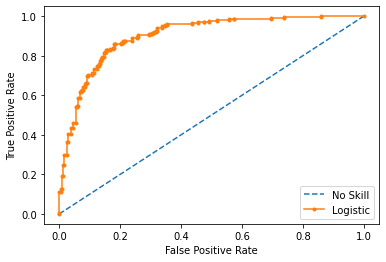

In [ ]:

# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
b = []
sm = nn.Softmax(dim = 1)
a = torch.tensor([[1.23, 2.85]])
output = sm(a)
b.append(output[:,0].tolist())
c = torch.tensor([[2.23, 1.85]])
output = sm(c)
b.append(output[:,0].tolist())

# **AlexNet**
---

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = models.alexnet(pretrained=True)
#set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [ ]:
# Train the model
net_trained = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
torch.save(net_trained,'model1.h5')

In [ ]:
model_ft = models.alexnet(pretrained=True)
feats_list = list(model_ft.features)
new_feats_list = []
for feat in feats_list:
    new_feats_list.append(feat)
    if isinstance(feat, nn.Conv2d):
        new_feats_list.append(nn.Dropout(p=0.5, inplace=True))
# modify convolution layers
model_ft.features = nn.Sequential(*new_feats_list)
#num_ftrs = model_ft.classifier[0].out_features
model_ft.classifier[0] = nn.Dropout (p = 0.4)
model_ft.classifier[3] = nn.Dropout (p = 0.4)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
# Train the model
net_trained = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
torch.save(net_trained,'model2.h5')

Epoch 0/24
----------
train Loss: 0.7233 Acc: 0.6957
test Loss: 0.5373 Acc: 0.8016
Test error: 253; test accuracy: 0.8015686274509803

Epoch 1/24
----------
train Loss: 0.4731 Acc: 0.7844
test Loss: 0.4759 Acc: 0.8157
Test error: 235; test accuracy: 0.8156862745098039

Epoch 2/24
----------
train Loss: 0.4355 Acc: 0.8064
test Loss: 0.4843 Acc: 0.7976
Test error: 258; test accuracy: 0.7976470588235294

Epoch 3/24
----------
train Loss: 0.4112 Acc: 0.8221
test Loss: 0.4951 Acc: 0.7725
Test error: 290; test accuracy: 0.7725490196078431

Epoch 4/24
----------
train Loss: 0.3915 Acc: 0.8279
test Loss: 0.4271 Acc: 0.8424
Test error: 201; test accuracy: 0.8423529411764705

Epoch 5/24
----------
train Loss: 0.3776 Acc: 0.8317
test Loss: 0.3944 Acc: 0.8690
Test error: 167; test accuracy: 0.8690196078431373

Epoch 6/24
----------
train Loss: 0.3550 Acc: 0.8487
test Loss: 0.4497 Acc: 0.8267
Test error: 221; test accuracy: 0.8266666666666667

Epoch 7/24
----------
train Loss: 0.3447 Acc: 0.8426
te

# **B-LRP**
---

## **Vgg-PreTrianed**

In [ ]:
#For Pretrained VGG Model
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import h5py
from scipy.ndimage.interpolation import rotate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import os
import copy

In [ ]:
!unzip Mosq.zip
!rm Mosq.zip

In [ ]:
!mv  Mosq/val  Mosq/test

In [ ]:
loss_ = []
test_accuracy = []
test_error = []

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Mosq/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#from torch.utils.tensorboard import SummaryWriter
#from math import sqrt
#writer = SummaryWriter()
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            #if phase == 'train':
                #writer.add_scalar(f'Runs/Loss/train', epoch_loss, epoch)
                #writer.add_scalar(f'Runs/Acc/train', epoch_acc, epoch)
            if phase == 'test':
                #temp_labels = np.array(labels.cpu())
                #temp_pred = np.array(preds.cpu())
                #test_accuracy.append(np.mean(temp_labels.data == temp_pred))
                #print(f'====>dataset_sizes {phase}={dataset_sizes[phase]}')
                #print(f'====>test_accuracy {phase}={test_accuracy[-1]}')
                test_accuracy.append(epoch_acc)
                test_error.append(int(dataset_sizes[phase]*(1-test_accuracy[-1])))
                print('Test error: {}; test accuracy: {}'.format(test_error[-1], test_accuracy[-1]))
                #writer.add_scalar(f'Runs/Loss/test', epoch_loss, epoch)
                #writer.add_scalar(f'Runs/Accuracy/test', epoch_acc, epoch)
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        #Tesst accuracy when it can only predict N% of the most accurate prediction
        #test(model, dataloaders['test'], device, epoch)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
net_trained = models.vgg16(pretrained=True)
feats_list = list(net_trained.features)
new_feats_list = []
for feat in feats_list:
    new_feats_list.append(feat)
    if isinstance(feat, nn.Conv2d):
        new_feats_list.append(nn.Dropout(p=0.5, inplace=True))
# modify convolution layers
net_trained.features = nn.Sequential(*new_feats_list)
net_trained.classifier[2] = nn.Dropout (p = 0.4)
net_trained.classifier[5] = nn.Dropout (p = 0.4)
num_ftrs = net_trained.classifier[6].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
net_trained.classifier[6] = nn.Linear(num_ftrs, 2)
net_trained = net_trained.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(net_trained.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

net_trained = train_model(net_trained, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

f = 'model.h5'
torch.save(net_trained.state_dict(), f)
#torch.save(net_trained,'model.h5')

In [ ]:
model = models.vgg16(pretrained=True)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load('model.h5'))
model.eval()

model.to(device)

In [ ]:
# --------------------------------------------------------------
# LRP Composite rule
# --------------------------------------------------------------
# More information at http://www.heatmapping.org/tutorial/

def LRP_CMP(image, class_id, model, dropout = True, verbose = False, device = 'cpu'):

    mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1).to(device)  # We define mean and std for data normalisation
    std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1).to(device)

    image = image.to(device)
    
    if not dropout:
        model.eval()
    else:
        model.train()

    X = (image.transpose(2,1).transpose(0,1).view([1,3,224,224]) - mean) / std
    
    layers = list(model._modules['features']) + toconv(list(model._modules['classifier']))
    L = len(layers)
    
    A = [X]+[None]*L
    with torch.no_grad():
      for l in range(L): A[l+1] = layers[l].forward(A[l]).to(device)
    
    scores = np.array(A[-1].data.view(-1).cpu())
    ind = np.argsort(-scores)
    
    if verbose:
        for i in ind[:5]:
            print('%20s (%3d): %6.3f'%(imgclasses[i][:20],i,scores[i]))

    T = torch.FloatTensor((1.0*(np.arange(2)==class_id).reshape([1,2,1,1]))).to(device)
    R = [None] * L + [(A[-1]*T)]

    for l in range(1,L)[::-1]:

        A[l] = A[l].requires_grad_(True)

        if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)
        
        if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):
            
            if l <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
            if 17 <= l <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
            if l >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9

            z = incr(newlayer(layers[l],rho).forward(A[l]))                     # step 1
            s = (R[l+1]/z).data                                                 # step 2
            (z*s).sum().backward(); c = A[l].grad                               # step 3
            R[l] = (A[l]*c).data                                                # step 4
            
        else:
            if not dropout:
              R[l] = R[l+1]
            else:
              if layers[l].children().__class__.__name__.startswith('Dropout'):
                  incr = lambda z: z+1e-9
                  z = incr(layers[l].forward(A[l], freeze = True))
                  s = (R[l+1]/z).data                                           # step 2
                  (z*s).sum().backward(); c = A[l].grad                         # step 3
                  R[l] = (A[l]*c).data                                          # step 4
              else:
                  R[l] = R[l+1]

    A[0] = A[0].requires_grad_(True)

    with torch.no_grad():
      lb = (A[0]*0+(0-mean)/std)
      hb = (A[0]*0+(1-mean)/std)
    
    lb = lb.requires_grad_(True)
    hb = hb.requires_grad_(True)

    z = layers[0].forward(A[0]) + 1e-9                                          # step 1 (a)
    z -= newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)               # step 1 (b)
    z -= newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)               # step 1 (c)
    s = (R[1]/z).data                                                           # step 2
    (z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad                 # step 3
    #print(c,cp,cm)
    R[0] = (A[0]*c+lb*cp+hb*cm).data
    
    return R[0].data

# --------------------------------------------------------------
# Clone a layer and pass its parameters through the function g
# --------------------------------------------------------------

def newlayer(layer,g):

    layer = copy.deepcopy(layer)

    try: layer.weight = nn.Parameter(g(layer.weight))
    except AttributeError: pass

    try: layer.bias   = nn.Parameter(g(layer.bias))
    except AttributeError: pass

    return layer
# --------------------------------------------------------------
# convert VGG classifier's dense layers to convolutional layers
# --------------------------------------------------------------

def toconv(layers):

    newlayers = []

    for i,layer in enumerate(layers):

        if isinstance(layer,nn.Linear):

            newlayer = None

            if i == 0:
                m,n = 512,layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,7)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,7,7))

            else:
                m,n = layer.weight.shape[1],layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,1)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,1,1))

            newlayer.bias = nn.Parameter(layer.bias)

            newlayers += [newlayer]

        else:
            newlayers += [layer]

    return newlayers
# --------------------------------------------------------------
# Function for MinMax Normalisation of Relevances
# --------------------------------------------------------------
def normalise_relevance(relevance_matrix):
    a = relevance_matrix.min()
    b = relevance_matrix.max()
    
    if (a == 0.) & (b == 0.):
        return relevance_matrix
    if (a > 0.):
      return (relevance_matrix >0.)*relevance_matrix/b
    if (b < 0.):
      return - (relevance_matrix <=0.)*relevance_matrix/a
    
    return (relevance_matrix >0.)*relevance_matrix/b  - (relevance_matrix <=0.)*relevance_matrix/a

In [ ]:
import cv2
img_name = '3.png'
img = np.array(cv2.imread(img_name))[...,::-1]/255.0

dim = (224,224)
img = cv2.resize(img, dim)
#plt.imshow(img)

img = torch.tensor(img).float().to(device)
class_ind = 0

#mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1).to(device)  # We define mean and std for data normalisation
#std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1).to(device)

#X = (img.transpose(2,1).transpose(0,1).view([1,3,224,224]) - mean) / std
#X

In [ ]:
from tqdm import tqdm_notebook as tqdm
N_MC = 100 # Number of samples from the posterior
model.to(device)
LRPs = torch.zeros([N_MC, 224, 224])
Standard_LRP = torch.zeros([224, 224])

counter = 0

for i in tqdm(range(N_MC)):
  LRPs[i] = LRP_CMP(img, class_ind, model, dropout = True, device = device)[0].sum(axis = 0).data
  LRPs[i][LRPs[i] != LRPs[i]] = 0.

Standard_LRP = LRP_CMP(img, class_ind, model, dropout = False, device = device)[0].sum(axis = 0).data
Standard_LRP[Standard_LRP != Standard_LRP] = 0.

In [ ]:
#plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 20})
alphas = [5,25,50,75,95]

LRPs = LRPs.to('cpu')
fig, ax = plt.subplots(1, 3, figsize=(15.6,3))

ax[0].imshow(img.cpu(), cmap = 'gray')
ax[0].title.set_text('Original Image')
ax[0].xaxis.set_major_locator(plt.NullLocator())
ax[0].yaxis.set_major_locator(plt.NullLocator())

ax[1].imshow(normalise_relevance(Standard_LRP.cpu()), cmap = 'seismic')
ax[1].title.set_text('Standard LRP')
ax[1].xaxis.set_major_locator(plt.NullLocator())
ax[1].yaxis.set_major_locator(plt.NullLocator())

ax[2].imshow(normalise_relevance(LRPs.mean(axis  = 0)), cmap = 'seismic')
ax[2].title.set_text('Expected LRP')
ax[2].xaxis.set_major_locator(plt.NullLocator())
ax[2].yaxis.set_major_locator(plt.NullLocator())

fig, ax = plt.subplots(1, len(alphas), figsize=(14,6))

cols = ['{}-th Percentile'.format(col) for col in alphas]

for axe, col in zip(ax, cols):
    axe.set_title(col)

for i in range(len(alphas)):
    ax[i].imshow(normalise_relevance(np.percentile(LRPs.reshape([N_MC, - 1]).numpy(), alphas[i], axis = 0).reshape([224,224])), cmap='seismic')
    ax[i].xaxis.set_major_locator(plt.NullLocator())
    ax[i].yaxis.set_major_locator(plt.NullLocator())
plt.show()

## **Generate Histograms**

In [ ]:
from __future__ import print_function
import math
import matplotlib.pyplot as plt
import os

import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import warnings
warnings.simplefilter(action='ignore')

def apply_dropout(m):
    for each_module in m.children():
        if each_module.__class__.__name__.startswith('Dropout'):
            each_module.train()
    return m

def enable_dropout(m):
  for each_module in m.modules():
    if each_module.__class__.__name__.startswith('Dropout'):
      each_module.train()

def uncertainties(p):
    aleatoric = np.mean(p*(1-p), axis=0)
    epistemic = np.mean(p**2, axis=0) - np.mean(p, axis=0)**2
    return aleatoric, epistemic


In [ ]:
#----------------------------CHOOSE RANDOM IMAGE----------------------------------------------
for test_images, test_labels in dataloaders['test']:  
    sample_image = test_images[2]
    sample_label = test_labels[2]

T = 100 # how many times to apply drop-out at test time

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    #plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
#sns.set(rc={'figure.figsize':(14,6)})
#plt.gcf().set_size_inches(11.7, 8.27)
def plothist(grdtruth, prediction, flag):
  #for i in prediction:
  mean = np.mean(prediction)
  std = np.std(prediction)
  if std>=0.1:
    dec = "Uncertain"
  else:
    dec = "Certain"
  if flag == 1 and std <= 0.1:
    sns.displot(prediction, kind="kde", bw_adjust=.6, fill=True, color= '#ff6c70', label = 'Correct', legend=True)
  elif flag == 1 and std > 0.1:
    sns.displot(prediction, kind="kde", bw_adjust=.6, fill=True, color= '#ff6c70', label = 'Correct', legend=True)
  else:
    #sns.displot(grdtruth, kind="kde", bw_adjust=.6, fill=True, color= '#ff6c70', label = 'Grd Truth')
    #sns.displot(prediction, kind="kde", bw_adjust=.6, fill=True, color= '#00DBFF', label = 'Pred.')
    sns.displot([grdtruth, prediction], kind="kde", bw_adjust=.6, fill=True,
                color= ['#ff6c70',  '#00DBFF'], legend=True)
  #sns.displot(ntpred, kind="kde", bw_adjust=.6, fill=True, color='#ff6c70', label = 'incorrect', legend=True)
  
  plt.title("$μ$: {:.3f} $σ$: {:.3f}  {}".format(mean, std, dec), loc='left', fontsize=22)
  #plt.text("$σ$: {:.3f}  {}".format(std, dec), fontsize=14, ha='center', va='center')
  #plt.title("p(Tiger | image)", fontsize=20)
  plt.xlabel("Observations", fontsize=20)
  plt.ylabel("Density", fontsize=20)
  #plt.legend()
  #sns.displot(prediction[1], kind="kde", bw_adjust=.6, fill=True, color='#EF9A9A')
  #sns.plt.show()

In [ ]:
import numpy as np
pred = []
#----------------------------PREDICT-------------------------------------------
def predict(model, image, label, T=T):
    enable_dropout(model)
    # prepare label
    label = label.item()
    # prepare image
    #image = image.flatten()
    image = image.unsqueeze(0).to(device)
    #image.to(device)
    standard_output = model(image)
    _, standard_prediction = standard_output.max(0)
    model.train()
    # each vector will consist of T elements- the class-specific predictive probability from each model
    zero_p_hat= []
    one_p_hat= []

    #for idx, (images, labels) in enumerate(test_lloader):
            #images = images.to(device)
            #labels = labels.to(device)
    # predict stochastic dropout model T times
    for t in range(T):
        enable_dropout(model) 
        output = model(Variable(image))
        output = output.detach().cpu()
        output_prob1 = np.exp(output) #convert to predictive probabilities
        output_prob = F.softmax(output_prob1, dim=1)
        zero_p_hat.append(output_prob[0][0].item()) # P( c = 0 | image)
        one_p_hat.append(output_prob[0][1].item()) # P( c = 1 | image)

    # mean prediction
    zero_var = np.var(zero_p_hat)
    one_var = np.var(one_p_hat)

    #pred = zero_p_hat
    
    # will be a list of 10 elements, the variance of each class's predictions across T models
    class_specific_uncertainties = [zero_var, one_var]
    variance_of_class_specific_predictions = class_specific_uncertainties[label]
    p_hat_lists = [zero_p_hat, one_p_hat]
    

    return standard_prediction[0].item(), variance_of_class_specific_predictions, p_hat_lists[label], p_hat_lists

In [ ]:
# Dropout at test-time for uncertainty estimation
vgg1_models = torch.load('model1.h5',map_location={'cuda:0': 'cpu'})
vgg1_models.to(device)
prediction, var_uncertainty, samplePred, allSamples = predict(vgg1_models, sample_image, sample_label)

print(f'The model predicts: {prediction} ')
print(f'The ground truth: {sample_label}')
print(f'The number of samplings: {T}')
print(f'Variance of class-specific predictions across the models: {var_uncertainty}')
#print(f'Aleatoric and epistemic uncertainty: {aleatoric}')
#print(f'Epistemic uncertainty: {epistemic}')
#print(f'Moodels predictive probability: {_}')
#imshow(inp = sample_image, title = sample_label)
lbl = sample_label.item()
imshow(inp = sample_image, title = lbl)
if prediction == sample_label:
  flag = 1
else:
  flag = 0
plothist(allSamples[lbl], allSamples[prediction], flag)

In [ ]:
#----------------------------CHOOSE RANDOM IMAGE----------------------------------------------
for test_images, test_labels in dataloaders['test']:  
    sample_image = test_images[2]
    sample_label = test_labels[2]

T = 100 
sample_label

tensor(1)

In [ ]:
# Dropout at test-time for uncertainty estimation
vgg2_models = torch.load('model2.h5',map_location={'cuda:0': 'cpu'})
vgg2_models.to(device)
prediction, var_uncertainty, samplePred, allSamples = predict(vgg2_models, sample_image, sample_label)

print(f'The model predicts: {prediction} ')
print(f'The ground truth: {sample_label}')
print(f'The number of samplings: {T}')
print(f'Variance of class-specific predictions across the models: {var_uncertainty}')
#print(f'Aleatoric and epistemic uncertainty: {aleatoric}')
#print(f'Epistemic uncertainty: {epistemic}')
#print(f'Moodels predictive probability: {_}')
#imshow(inp = sample_image, title = sample_label)
lbl = sample_label.item()
imshow(inp = sample_image, title = lbl)
if prediction == sample_label:
  flag = 1
else:
  flag = 0
plothist(allSamples[lbl], allSamples[prediction], flag)

# **Experiment With Mosquito (AL)**
---

In [ ]:
import random
import os
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms
from torchvision import utils, models

def is_image(filename):
    return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])


In [ ]:
!unzip Mosq.zip
!rm Mosq.zip

In [ ]:
!mv Mosq/val Mosq/test

In [ ]:
!mv Mosq/train/Tiger Mosq/train/0_Tiger 
!mv Mosq/train/vNonTiger Mosq/train/1_vNonTiger
!mv Mosq/test/Tiger Mosq/test/0_Tiger 
!mv Mosq/test/vNonTiger Mosq/test/1_vNonTiger

In [ ]:
class IndexedDataset(Dataset):

    def __init__(self, dir_path, transform=None, test=False):
        '''
        Args:
        - dir_path (string): path to the directory containing images
        - transform (torchvision.transforms.) (default=None)
        - test (boolean): True for labeled images, False otherwise (default=False)
        '''

        self.dir_path = dir_path
        self.transform = transform
        
        image_filenames = []
        for (dirpath, dirnames, filenames) in os.walk(dir_path):
            image_filenames += [os.path.join(dirpath, file) for file in filenames if is_image(file)]
        self.image_filenames = image_filenames    
        
        # We assume that in the beginning, the entire dataset is unlabeled, unless it is flagged as 'test':
        if test:
            # The image's label is given by the first digit of its subdirectory's name
            # E.g. the label for the image file `./dogs/train/6_great_dane/n02109047_22481.jpg` is 6
            self.labels = [int(f[len(self.dir_path)+1]) for f in self.image_filenames]
            self.unlabeled_mask = np.zeros(len(self.image_filenames))
        else:
            self.labels =[0]*len(self.image_filenames)
            self.unlabeled_mask = np.ones(len(self.image_filenames))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        img_name = self.image_filenames[idx]
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx], idx
    
    # Display the image [idx] and its filename
    def display(self, idx):
        img_name = self.image_filenames[idx]
        print(img_name)
        img=mpimg.imread(img_name)
        imgplot = plt.imshow(img)
        plt.show()
        return
    
    # Set the label of image [idx] to 'new_label'
    def update_label(self, idx, new_label):
        self.labels[idx] = new_label
        self.unlabeled_mask[idx] = 0
        return
    
    # Set the label of image [idx] to that read from its filename
    def label_from_filename(self, idx):
        self.labels[idx] = int(self.image_filenames[idx][len(self.dir_path)+1])
        self.unlabeled_mask[idx] = 0
        return

In [ ]:
def enable_dropout(m):
  for each_module in m.modules():
    if each_module.__class__.__name__.startswith('Dropout'):
      each_module.train()

def mcdropout_query(model, device, data_loader, query_size=5):
    confidences = []
    indices = []
    pred = []
    T = 10
    print(len(data_loader))
    with torch.no_grad():
        for batch in data_loader:
            data, _, idx = batch
            enable_dropout(model)
            #model.train()
            for i in range(T):
                logits = model(data.to(device))
                probabilities = F.softmax(logits, dim=1)
                # Keep only the top class confidence for each sample
                most_probable = torch.max(probabilities, dim=1)[0]
                #temp = [i for i in zip(idx, most_probable)]
                #sumindex = [sum(elts) for elts in zip(*lisolis)]
                pred.append(most_probable.cpu().tolist())

            tempstd = [np.std(elts) for elts in zip(*pred)]
            confidences.extend(tempstd)
            indices.extend(idx.tolist())
    #print(f'tempstd: {tempstd}')    
    #conf = np.asarray(tempstd)
    conf = np.asarray(confidences)
    indices = list(map(int, indices))
    ind = np.asarray(indices)
    sorted_pool = np.argsort(-conf)
    #sorted_pool = conf.argsort()[::-1]
    #sorted_pool = conf.argsort()
    #print(f'sorted_pool: {sorted_pool}')
    #print(f'Index: {ind}')
    return ind[sorted_pool][0:query_size]

def least_confidence_query(model, device, data_loader, query_size=5):

    confidences = []
    indices = []
    
    model.eval()
    print(len(data_loader))
    with torch.no_grad():
        for batch in data_loader:
        
            data, _, idx = batch
            logits = model(data.to(device))
            probabilities = F.softmax(logits, dim=1)
            
            # Keep only the top class confidence for each sample
            most_probable = torch.max(probabilities, dim=1)[0]
            confidences.extend(most_probable.cpu().tolist())
            indices.extend(idx.tolist())
            
    conf = np.asarray(confidences)
    ind = np.asarray(indices)
    sorted_pool = np.argsort(conf)

    return ind[sorted_pool][0:query_size]

def random_query(data_loader, query_size=5):
    sample_idx = []
    # Because the data has already been shuffled inside the data loader,
    # we can simply return the `query_size` first samples from it
    print(len(data_loader))
    for batch in data_loader:
        
        _, _, idx = batch
        sample_idx.extend(idx.tolist())

        if len(sample_idx) >= query_size:
            break
    return sample_idx[0:query_size]



In [ ]:
'''
Queries the oracle (user, if `interactive` is set to True) for  labels for'query_size' 
samples using 'query_strategy'

'''
def query_the_oracle(model, device, dataset, query_size=5, query_strategy='random', 
                     interactive=False, pool_size=0, batch_size=128, num_workers=2):
    
    unlabeled_idx = np.nonzero(dataset.unlabeled_mask)[0]
    
    # Select a pool of samples to query from
    if pool_size > 0:    
        pool_idx = random.sample(range(1, len(unlabeled_idx)), pool_size)
        pool_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers,
                                              sampler=SubsetRandomSampler(unlabeled_idx[pool_idx]))
    else:
        pool_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers,
                                              sampler=SubsetRandomSampler(unlabeled_idx))

    if query_strategy == 'least_confidence':
        sample_idx = least_confidence_query(model, device, pool_loader, query_size)
    elif query_strategy == 'mcdropout':
        sample_idx = mcdropout_query(model, device, pool_loader, query_size)
    else:
        sample_idx = random_query(pool_loader, query_size)
    
    #print(f'lenght of sample index {len(sample_idx)}')
    # Query the samples, one at a time
    for sample in sample_idx:
        
        if interactive:
            dataset.display(sample)
            print("What is the class of this image?")
            new_label = int(input())
            dataset.update_label(sample, new_label)
            
        else:
            dataset.label_from_filename(sample)
def train(model, device, train_loader, optimizer, criterion, datalen):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for batch in train_loader:
        data, target, _ = batch
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = model(data)
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * data.size(0)
        running_corrects += torch.sum(preds == target.data)
        #print(f'Correct predicts: {torch.sum(preds == target.data)}/{datalen}, {32*len(train_loader)}')
    epoch_loss = running_loss / datalen
    epoch_acc = running_corrects.double() / datalen
    print('Loss: {:.3f} Acc: {:.3f}'.format(epoch_loss, epoch_acc))
    writer.add_scalar(f'Runs/Loss/train', epoch_loss, datalen)
    writer.add_scalar(f'Runs/Accuracy/ttrain', epoch_acc, datalen)
    
    return epoch_loss, epoch_acc

def test(model, device, test_loader, criterion, display=False):
    model.eval()
    test_loss = 0
    n_correct = 0
    one = torch.ones(1, 1).to(device)
    zero = torch.zeros(1, 1).to(device)
    with torch.no_grad():
        for batch in test_loader:
            data, target, _ = batch
            data, target = data.to(device), target.to(device)
            output = model(data)
            #test_loss += criterion(output.squeeze(), target.squeeze()).item()  # sum up batch loss
            test_loss += criterion(output, target).item()
            prediction = output.argmax(dim=1, keepdim=True)
            torch.where(output.squeeze()<0.5, zero, one)  # get the index of the max log-probability
            n_correct += prediction.eq(target.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset) 
    if display:
        print(f'==> Test Accuracy: {(100. * n_correct / len(test_loader.dataset)):2f}, Loss: {test_loss:2f}, Len: {len(test_loader.dataset)}')
        #print('Accuracy on the test set: ', (100. * n_correct / len(test_loader.dataset)))
    return test_loss, (100. * n_correct / len(test_loader.dataset))

In [ ]:
!rm -rf runs/

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from math import sqrt

writer = SummaryWriter()

np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(42)

train_dir = './Mosq/train'
test_dir = './Mosq/test'

device = torch.device("cuda")

train_set = IndexedDataset(train_dir, 
                           transform=transforms.Compose([
                                                         transforms.Resize((224, 224)),
                                                         transforms.ToTensor()]), test=False)
test_set = IndexedDataset(test_dir, transform=transforms.Compose([transforms.Resize((224, 224)), 
                                                                transforms.ToTensor()]), test=True) 
test_loader = DataLoader(test_set, batch_size=10, shuffle=True, num_workers=2)

print('Train set size: ', len(train_set))
print('Test set size: ', len(test_set))

testLen = len(test_set)
# Number of classes in the classification problem
n_classes = 2
query_size = 100
batch_size = 50

#classifier = models.vgg16(pretrained=True)
#num_ftrs = classifier.classifier[6].in_features
#classifier.classifier[6] = nn.Linear(num_ftrs, n_classes)
#classifier = classifier.to(device) 
classifier = models.vgg16(pretrained=True)
feats_list = list(classifier.features)
new_feats_list = []
for feat in feats_list:
    new_feats_list.append(feat)
    if isinstance(feat, nn.Conv2d):
        new_feats_list.append(nn.Dropout(p=0.5, inplace=True))
# modify convolution layers
classifier.features = nn.Sequential(*new_feats_list)
classifier.classifier[2] = nn.Dropout (p = 0.4)
classifier.classifier[5] = nn.Dropout (p = 0.4)
num_ftrs = classifier.classifier[6].in_features
classifier.classifier[6] = nn.Linear(num_ftrs, 2)
classifier = classifier.to(device) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9, dampening=0, weight_decay=0.0001)
        
# Label the initial subset
query_the_oracle(classifier, device, train_set, query_size=query_size, interactive=False, query_strategy='random',
                 pool_size=0)

# How many times should the oracle be queried
#num_queries = 5

# Pre-train on the initial subset
labeled_idx = np.where(train_set.unlabeled_mask == 0)[0]
labeled_loader = DataLoader(train_set, batch_size=batch_size, num_workers=2, 
                            sampler=SubsetRandomSampler(labeled_idx))
previous_test_acc = 0
current_test_acc = 1
datalen = len(labeled_idx)
while current_test_acc > previous_test_acc:
    previous_test_acc = current_test_acc
    train_loss, epoch_acc = train(classifier, device, labeled_loader, optimizer, criterion, datalen)
    _, current_test_acc = test(classifier, device, test_loader, criterion)

loss, testacc, = test(classifier, device, test_loader, criterion, display=True)
#while testacc < 90:
#for i in range(5):
while len(labeled_idx) < len(train_set):
    # Query the oracle for more labels
    query_size = 50
    query_the_oracle(classifier, device, train_set, query_size=query_size, query_strategy='least_confidence', interactive=False, pool_size=0)
    # Train the model on the data that has been labeled so far:
    labeled_idx = np.where(train_set.unlabeled_mask == 0)[0]
    labeled_loader = DataLoader(train_set, batch_size=batch_size, num_workers=2, sampler=SubsetRandomSampler(labeled_idx))
    previous_test_acc = 0
    current_test_acc = 1
    datalen = len(labeled_idx)
    #print(f'labelled index2:{datalen}')
    while current_test_acc > previous_test_acc:
        previous_test_acc = current_test_acc
        train_loss, epoch_acc = train(classifier, device, labeled_loader, optimizer, criterion, datalen)
        loss, current_test_acc = test(classifier, device, test_loader, criterion)
        testacc = current_test_acc
    #print(f'curr.test.acc:{current_test_acc:2f} trainlen:{len(labeled_idx)}')
    writer.add_scalar(f'Runs/Loss/test', loss, len(labeled_idx))
    writer.add_scalar(f'Runs/Accuracy/test', current_test_acc, len(labeled_idx))
    # Test the model:
    test(classifier, device, test_loader, criterion, display=True)
print('Done!')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs/

In [ ]:
!zip -r runs.zip runs/

  adding: runs/ (stored 0%)
  adding: runs/Dec15_09-40-26_cf3b73d43944/ (stored 0%)
  adding: runs/Dec15_09-40-26_cf3b73d43944/events.out.tfevents.1608025227.cf3b73d43944.56.0 (deflated 5%)
  adding: runs/Dec15_15-21-22_cf3b73d43944/ (stored 0%)
  adding: runs/Dec15_15-21-22_cf3b73d43944/events.out.tfevents.1608045683.cf3b73d43944.18086.0 (deflated 71%)
  adding: runs/Dec15_12-41-22_cf3b73d43944/ (stored 0%)
  adding: runs/Dec15_12-41-22_cf3b73d43944/events.out.tfevents.1608036082.cf3b73d43944.56.2 (deflated 71%)
  adding: runs/Dec15_09-45-33_cf3b73d43944/ (stored 0%)
  adding: runs/Dec15_09-45-33_cf3b73d43944/events.out.tfevents.1608025533.cf3b73d43944.56.1 (deflated 71%)
